#**In this file,we tried AlexNet and one custom model with 1 skip connection**

**Importing libraries**

In [ ]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import Sequence
from random import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/univ.ai2_project


/content/drive/MyDrive/univ.ai2_project


In [ ]:
# unzipping dats files
import zipfile
with zipfile.ZipFile('Post-hurricane.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
#getting files
def get_files(directory):
    df = pd.DataFrame(columns=['file','target'])
    damage = glob.glob(directory+'/damage/*.jpeg'
    no_damage = glob.glob(directory+'/no_damage/*jpeg')
    for f in damage:
        df = df.append({'file':f,'target':'1'},ignore_index=True)
    for f in no_damage:
        df = df.append({'file':f,'target':'0'},ignore_index=True)
    return df

def get_image(file_path):
    return mpimg.imread(file_path)/255

preparing the dataframes

In [ ]:

df_train = get_files('/content/drive/MyDrive/univ.ai2_project/train_another')


In [ ]:
df_validation = get_files('/content/drive/MyDrive/univ.ai2_project/validation_another')


In [ ]:
df_test = get_files('/content/drive/MyDrive/univ.ai2_project/test')

In [ ]:
df_test_biased = get_files('/content/drive/MyDrive/univ.ai2_project/test_another')

In [ ]:
df_train.reset_index(inplace=True,drop=True)

In [ ]:
df_test.head()

,file,target
0,/content/drive/MyDrive/univ.ai2_project/test/d...,1
1,/content/drive/MyDrive/univ.ai2_project/test/d...,1
2,/content/drive/MyDrive/univ.ai2_project/test/d...,1
3,/content/drive/MyDrive/univ.ai2_project/test/d...,1
4,/content/drive/MyDrive/univ.ai2_project/test/d...,1


In [ ]:
df_train.shape

(10000, 2)

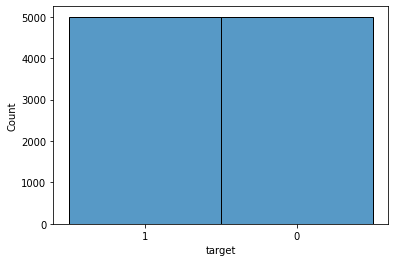

In [ ]:
ax = sns.histplot(x='target', data=df_train, bins=2)
#ax.set_xticks([0.25,0.75])
#ax.set_xticklabels([0,1])
plt.show()


In [ ]:
df_test.shape

(2000, 2)

Checking the images of labelled images

In [ ]:
img = get_image(df_train[df_train['target']=='1']['file'].iloc[0])
img.shape

(128, 128, 3)

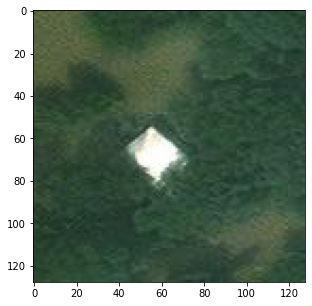

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.imshow(img)

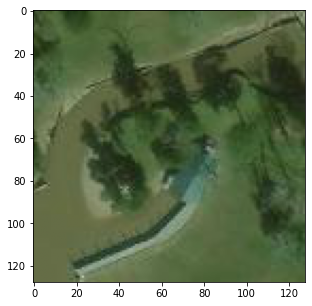

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.imshow(get_image(df_train[df_train['target']=='0']['file'].iloc[0]))

Define the data structure for the model

In [ ]:
train_gen = ImageDataGenerator(validation_split=0.1,rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness))
test_gen = ImageDataGenerator(rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness)


train_data = train_gen.flow_from_dataframe(
    dataframe = df_train,
    x_col = 'file',
    y_col = 'target',
    target_size = (256,256),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = True,
    subset = 'training',
    batch_size=100
)

val_data = train_gen.flow_from_dataframe(
    dataframe = df_validation,
    x_col = 'file',
    y_col = 'target',
    target_size = (256,256),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = False,
    subset = 'validation',
    batch_size=100
)

test_data = test_gen.flow_from_dataframe(
    dataframe = df_test,
    x_col = 'file',
    y_col = 'target',
    target_size = (256,256),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = False,
    batch_size=100
)


test_data_biased = test_gen.flow_from_dataframe(
    dataframe = df_test_biased,
    x_col = 'file',
    y_col = 'target',
    target_size = (256,256),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = False,
    batch_size=100
)

Found 9000 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 9000 validated image filenames belonging to 2 classes.


custom model (the model with least accuracy so we decided not to add in the report coz we already have included a lot of good models to show)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
   
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall']
)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 30, 30, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 30, 30, 256)       614656    
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 14, 14, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 14, 14, 384)       885120    
                                                                 
 conv2d_64 (Conv2D)          (None, 14, 14, 384)     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_data,epochs=6,validation_data=val_data)

Epoch 1/6
90/90 [==============================] - 199s 2s/step - loss: 0.8296 - accuracy: 0.5307 - recall: 0.4305 - val_loss: 1.0142 - val_accuracy: 0.2700 - val_recall: 0.2700
Epoch 2/6
90/90 [==============================] - 196s 2s/step - loss: 0.7646 - accuracy: 0.5799 - recall: 0.5035 - val_loss: 0.8410 - val_accuracy: 0.4950 - val_recall: 0.4950
Epoch 3/6
90/90 [==============================] - 195s 2s/step - loss: 0.7033 - accuracy: 0.6301 - recall: 0.5535 - val_loss: 0.7486 - val_accuracy: 0.5400 - val_recall: 0.5400
Epoch 4/6
90/90 [==============================] - 193s 2s/step - loss: 0.6634 - accuracy: 0.6552 - recall: 0.5880 - val_loss: 0.7267 - val_accuracy: 0.6250 - val_recall: 0.6250
Epoch 5/6
90/90 [==============================] - 193s 2s/step - loss: 0.6364 - accuracy: 0.6840 - recall: 0.6233 - val_loss: 0.8670 - val_accuracy: 0.5350 - val_recall: 0.5350
Epoch 6/6
90/90 [==============================] - 194s 2s/step - loss: 0.5972 - accuracy: 0.7078 - recall: 0.

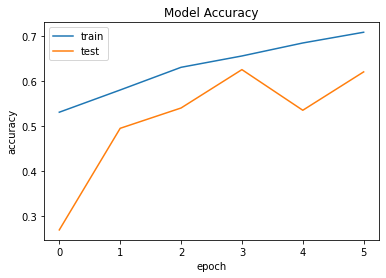

In [ ]:
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

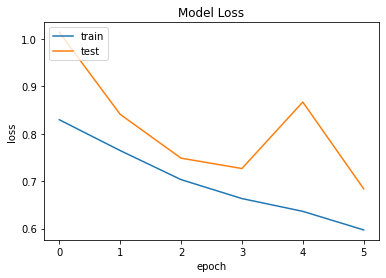

In [ ]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
y_pred = model.predict(test_data)
y_pred = np.where(y_pred > 0.5,1,0)

In [ ]:
print(classification_report(test_data.labels,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1000
           1       0.81      0.75      0.78      1000

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000



In [ ]:
con_mat_df = pd.DataFrame(confusion_matrix(test_data.labels,y_pred))

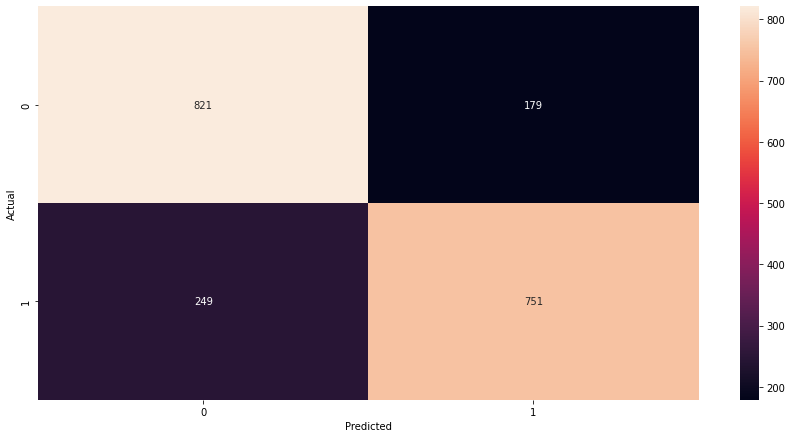

In [ ]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
model = tf.keras.Sequential([
        keras.layers.InputLayer(input_shape=(256,256,3)),
        keras.layers.Conv2D(3,3,activation='relu',padding='same'),
        EfficientNetB0(include_top=False,input_shape=(),weights='imagenet'),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(32,activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')])

model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 256, 256, 3)       84        
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_13 (Dense)            (None, 32)                40992     
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,090,680
Trainable params: 4,048,657
Non-trainable params: 42,023
_______________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_data,epochs=15,validation_data=val_data)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Alexanet model

In [ ]:
model_alex_net = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
model_alex_net.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall']
)

In [ ]:
model_alex_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
history = model_alex_net.fit(train_data,epochs=15,validation_data=val_data)

Epoch 1/15
90/90 [==============================] - 196s 2s/step - loss: 1.0784 - accuracy: 0.5666 - recall: 0.4403 - val_loss: 0.7593 - val_accuracy: 0.5650 - val_recall: 0.5650
Epoch 2/15
90/90 [==============================] - 191s 2s/step - loss: 0.9166 - accuracy: 0.6309 - recall: 0.5738 - val_loss: 0.6072 - val_accuracy: 0.7600 - val_recall: 0.7600
Epoch 3/15
90/90 [==============================] - 189s 2s/step - loss: 0.8587 - accuracy: 0.6654 - recall: 0.6277 - val_loss: 0.5685 - val_accuracy: 0.7300 - val_recall: 0.7300
Epoch 4/15
90/90 [==============================] - 189s 2s/step - loss: 0.8190 - accuracy: 0.6841 - recall: 0.6678 - val_loss: 0.8115 - val_accuracy: 0.6550 - val_recall: 0.6550
Epoch 5/15
90/90 [==============================] - 190s 2s/step - loss: 0.8041 - accuracy: 0.7013 - recall: 0.6780 - val_loss: 1.0542 - val_accuracy: 0.6050 - val_recall: 0.6050
Epoch 6/15
90/90 [==============================] - 191s 2s/step - loss: 0.7383 - accuracy: 0.7230 - reca

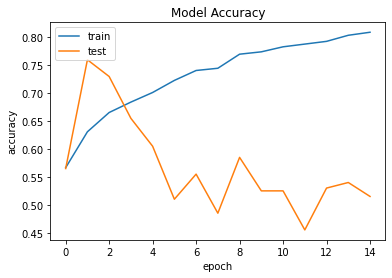

In [ ]:
import matplotlib.pyplot as plt
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#alexnet try 2 with early stopping
from keras. import ModelCheckpoint, EarlyStopping

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history2 = model_alex_net.fit(x=train_data,epochs=30,validation_data=val_data,callbacks=[callback])

Epoch 1/15
90/90 [==============================] - 194s 2s/step - loss: 0.5146 - accuracy: 0.8138 - recall: 0.7980 - val_loss: 1.5688 - val_accuracy: 0.4950 - val_recall: 0.4950
Epoch 2/15
90/90 [==============================] - 193s 2s/step - loss: 0.4864 - accuracy: 0.8273 - recall: 0.8098 - val_loss: 1.3172 - val_accuracy: 0.5400 - val_recall: 0.5400
Epoch 3/15
90/90 [==============================] - 192s 2s/step - loss: 0.4759 - accuracy: 0.8237 - recall: 0.8090 - val_loss: 1.3577 - val_accuracy: 0.5100 - val_recall: 0.5100
Epoch 4/15
90/90 [==============================] - 191s 2s/step - loss: 0.4650 - accuracy: 0.8308 - recall: 0.8127 - val_loss: 1.2366 - val_accuracy: 0.5600 - val_recall: 0.5600
Epoch 5/15
90/90 [==============================] - 192s 2s/step - loss: 0.4755 - accuracy: 0.8284 - recall: 0.8150 - val_loss: 1.3002 - val_accuracy: 0.5300 - val_recall: 0.5300
Epoch 6/15
90/90 [==============================] - 190s 2s/step - loss: 0.4391 - accuracy: 0.8399 - reca

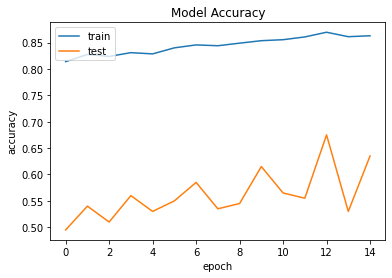

In [ ]:
#plotting the Accuracy of test and training sets
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# serialize model to JSON
model_json = model_alex_net.to_json()
with open("cnn_model3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_alex_net.save_weights("cnn_model_alex_net.h5")
print("Saved model to disk")


Saved model to disk


**Evaluating Alexnet on balanced test set**

In [ ]:
Alexresult_on_unbiased_train_data= model_alex_net.evaluate(test_data, batch_size=100)



20/20 [==============================] - 41s 2s/step - loss: 0.3620 - accuracy: 0.8585 - recall: 0.8040


In [ ]:
print("test loss, test acc:", Alexresult_on_unbiased_train_data)

test loss, test acc: [0.362043172121048, 0.8585000038146973, 0.8040000200271606]


In [ ]:
!pip3 install h5py==2.10.0

In [ ]:
model_alex_net.load_weights("/content/drive/MyDrive/univ.ai2_project/cnn_model_alex_net.h5")

In [ ]:
y_pred = model_alex_net.predict(test_data)
y_pred = np.where(y_pred > 0.5,1,0)

In [ ]:
print(classification_report(test_data.labels,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1000
           1       0.91      0.82      0.86      1000

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



Confusion matrix

In [ ]:
con_mat_df = pd.DataFrame(confusion_matrix(test_data.labels,y_pred))

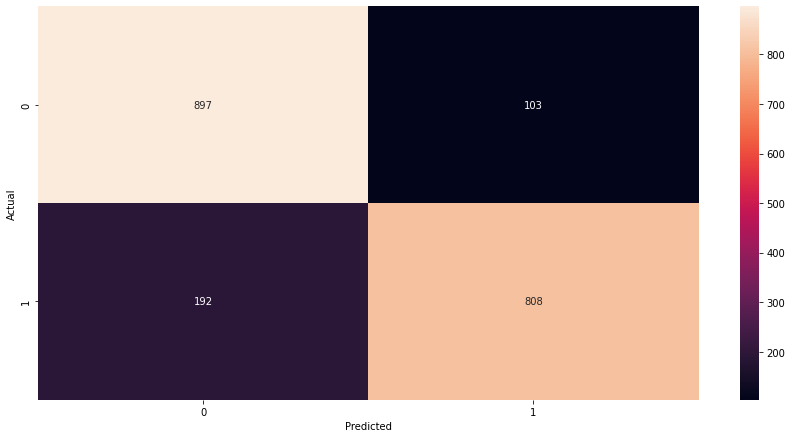

In [ ]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr, tpr, thresh = roc_curve(test_data.labels, y_pred, pos_label=1)

In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(test_data.labels, y_pred)

In [ ]:
print(auc_score1)

0.869


In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(test_data.labels, y_pred, pos_label=1)

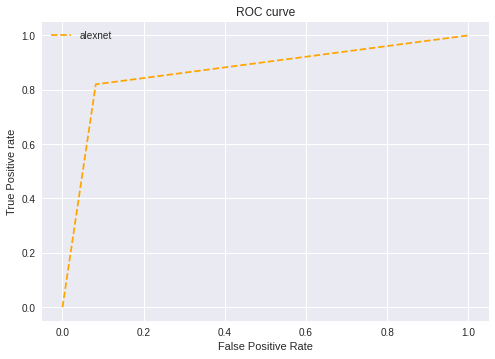

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='alexnet')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
#plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC_alexnet_biased',dpi=300)
plt.show();

#Testing alexnet on  **biased data**




In [ ]:
model_alex_net.load_weights("/content/drive/MyDrive/univ.ai2_project/cnn_model_alex_net.h5")

In [ ]:
y_pred_b = model_alex_net.predict(test_data_biased)
y_pred_b = np.where(y_pred_b > 0.5,1,0)

In [ ]:
print(classification_report(test_data_biased.labels,y_pred_b))

              precision    recall  f1-score   support

           0       0.39      0.90      0.55      1000
           1       0.99      0.83      0.90      8000

    accuracy                           0.84      9000
   macro avg       0.69      0.86      0.72      9000
weighted avg       0.92      0.84      0.86      9000



Confusion Matrix

In [ ]:
con_mat_df1 = pd.DataFrame(confusion_matrix(test_data_biased.labels,y_pred_b))

In [ ]:
con_mat_df1 = pd.DataFrame(confusion_matrix(test_data_biased.labels,y_pred_b))

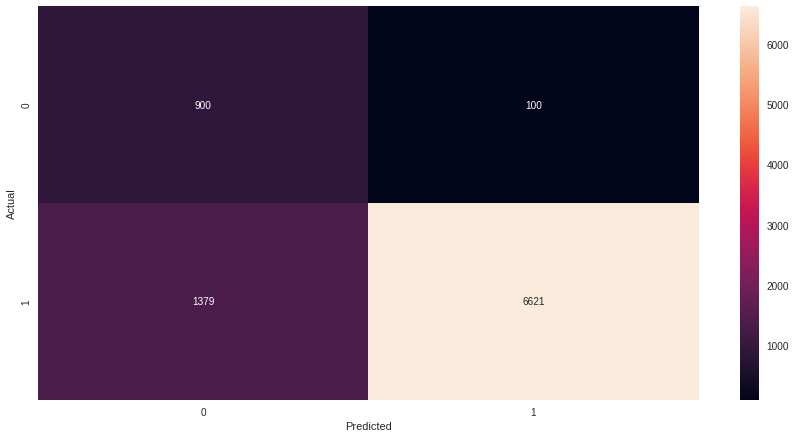

In [ ]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df1, annot=True,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('ROC_alex_net_biased_conf_matrix',dpi=300)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fprU, tprU, threshU = roc_curve(test_data_biased.labels, y_pred_b, pos_label=1)

In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_scoreU = roc_auc_score(test_data_biased.labels, y_pred_b)

In [ ]:
print(auc_scoreU)

0.8638125000000001


In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fprU, tprU, threshU = roc_curve(test_data_biased.labels, y_pred_b, pos_label=1)

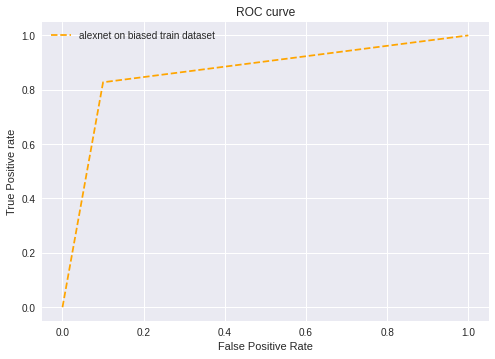

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='alexnet on biased train dataset')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
#plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC_alex_net_biased',dpi=300)
plt.show();

In [3]:
from prettytable import PrettyTable

table=PrettyTable(["model", "Train_accuracy","validation_accuracy", "Test_accuracy","Test_accuracy_unbalanced_data" ])
table.add_row(["AlexNet model","0.86 ",'0.63','0.87','0.84'])
print(table)

+---------------+----------------+---------------------+---------------+-------------------------------+
|     model     | Train_accuracy | validation_accuracy | Test_accuracy | Test_accuracy_unbalanced_data |
+---------------+----------------+---------------------+---------------+-------------------------------+
| AlexNet model |     0.86       |         0.63        |      0.87     |              0.84             |
+---------------+----------------+---------------------+---------------+-------------------------------+




### *Resnet from scratch* (its a custom model with one skip connection)

# Resnet

importing libraries

In [ ]:
# example of a CNN model with an identity or projection residual module
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras.layers import add
from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers

# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
      merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    
    # conv1
    conv1=Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)

    

    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)

    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    layer_out=BatchNormalization()(layer_out)
    layer_out=MaxPooling2D((3,3),strides=(2,2))(layer_out)
    return layer_out


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 3)  84          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 3)  84          ['conv2d[0][0]']                 
                                                                                                  
 add (Add)                      (None, 256, 256, 3)  0           ['conv2d_1[0][0]',           

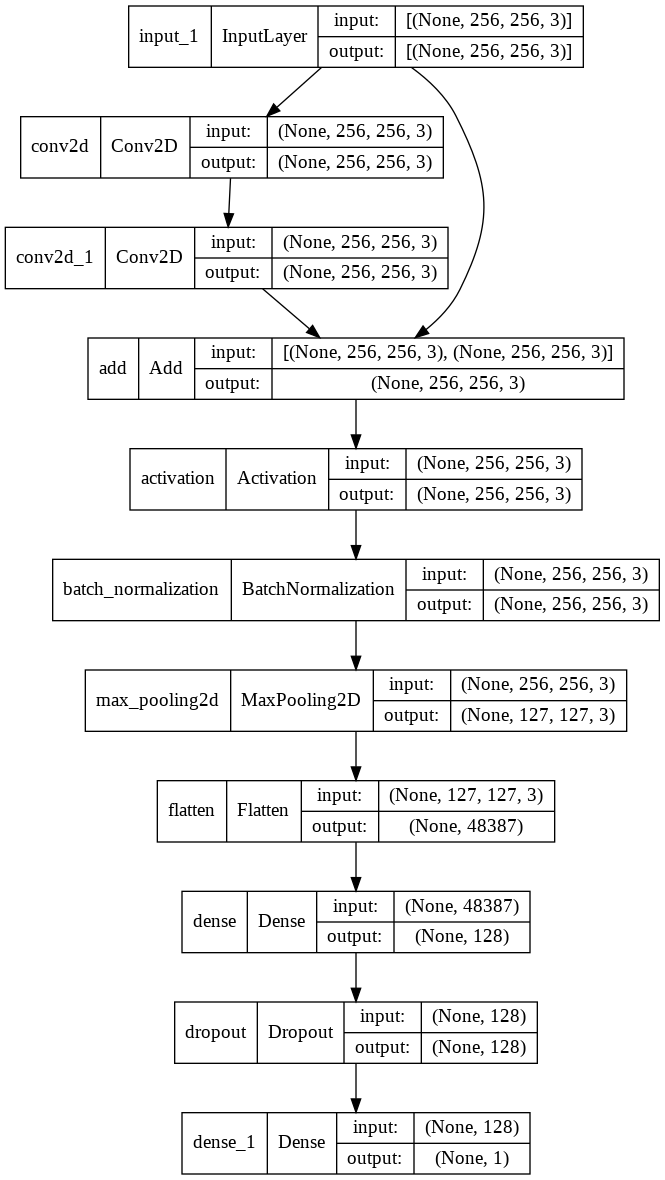

In [ ]:
# define model input
visible = Input(shape=(256, 256, 3))
# add vgg module
layer = residual_module(visible, 3)
layer = Flatten()(layer)
layer = Dense(128,activation='relu')(layer)
layer = layers.Dropout(0.5)(layer)
layer = Dense(1,activation='sigmoid')(layer)
# create model
resnmodel = Model(inputs=visible, outputs=layer)
# summarize model
resnmodel.summary()
# plot model architecture
plot_model(resnmodel, show_shapes=True, to_file='residual_module.png')

In [ ]:
resnmodel.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall'])
resnmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 3)  84          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 3)  84          ['conv2d[0][0]']                 
                                                                                                  
 add (Add)                      (None, 256, 256, 3)  0           ['conv2d_1[0][0]',           

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
checkpoint = keras.callbacks.ModelCheckpoint('model{epoch:08d}.h5', period=5) 
history3 = resnmodel.fit(train_data,epochs=20,validation_data=val_data,callbacks=[callback,checkpoint])

Epoch 1/20
90/90 [==============================] - 2173s 24s/step - loss: 0.7857 - accuracy: 0.5878 - recall: 0.5188 - val_loss: 0.5636 - val_accuracy: 0.7150 - val_recall: 0.7150
Epoch 2/20
90/90 [==============================] - 195s 2s/step - loss: 0.6946 - accuracy: 0.6473 - recall: 0.6020 - val_loss: 0.6290 - val_accuracy: 0.6700 - val_recall: 0.6700
Epoch 3/20
90/90 [==============================] - 193s 2s/step - loss: 0.6633 - accuracy: 0.6582 - recall: 0.6075 - val_loss: 0.6986 - val_accuracy: 0.6100 - val_recall: 0.6100
Epoch 4/20
90/90 [==============================] - 193s 2s/step - loss: 0.6703 - accuracy: 0.6631 - recall: 0.6108 - val_loss: 0.5070 - val_accuracy: 0.7850 - val_recall: 0.7850
Epoch 5/20
90/90 [==============================] - ETA: 0s - loss: 0.6468 - accuracy: 0.6730 - recall: 0.6283

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


90/90 [==============================] - 193s 2s/step - loss: 0.6468 - accuracy: 0.6730 - recall: 0.6283 - val_loss: 0.8012 - val_accuracy: 0.5550 - val_recall: 0.5550
Epoch 6/20
90/90 [==============================] - 194s 2s/step - loss: 0.6441 - accuracy: 0.6773 - recall: 0.6345 - val_loss: 0.8533 - val_accuracy: 0.5200 - val_recall: 0.5200
Epoch 7/20
90/90 [==============================] - 194s 2s/step - loss: 0.6283 - accuracy: 0.6846 - recall: 0.6410 - val_loss: 0.6714 - val_accuracy: 0.6950 - val_recall: 0.6950
Epoch 8/20
90/90 [==============================] - 193s 2s/step - loss: 0.6400 - accuracy: 0.6830 - recall: 0.6417 - val_loss: 0.7304 - val_accuracy: 0.6000 - val_recall: 0.6000
Epoch 9/20
90/90 [==============================] - 193s 2s/step - loss: 0.6144 - accuracy: 0.6943 - recall: 0.6532 - val_loss: 0.6231 - val_accuracy: 0.7200 - val_recall: 0.7200
Epoch 10/20
90/90 [==============================] - 192s 2s/step - loss: 0.6173 - accuracy: 0.6884 - recall: 0.6403

In [ ]:
# serialize model to JSON
model_json = resnmodel.to_json()
with open("resnmodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
resnmodel.save_weights("resnmodel2.h5")
print("Saved model to disk")

Saved model to disk


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
y_pred = resnmodel.predict(test_data)
y_pred = np.where(y_pred > 0.5,1,0)

In [ ]:
print(classification_report(test_data.labels,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1000
           1       0.75      0.72      0.74      1000

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



Try 2

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
checkpoint = keras.callbacks.ModelCheckpoint('model{epoch:08d}.h5', period=5) 
history3 = resnmodel.fit(train_data,epochs=15,validation_data=val_data,callbacks=[callback,checkpoint])

Epoch 1/15
90/90 [==============================] - 191s 2s/step - loss: 0.5898 - accuracy: 0.7048 - recall: 0.6620 - val_loss: 0.6525 - val_accuracy: 0.7100 - val_recall: 0.7100
Epoch 2/15
90/90 [==============================] - 189s 2s/step - loss: 0.5990 - accuracy: 0.7022 - recall: 0.6490 - val_loss: 0.6188 - val_accuracy: 0.7500 - val_recall: 0.7500
Epoch 3/15
90/90 [==============================] - 191s 2s/step - loss: 0.5906 - accuracy: 0.7089 - recall: 0.6650 - val_loss: 0.7536 - val_accuracy: 0.5950 - val_recall: 0.5950
Epoch 4/15
90/90 [==============================] - 189s 2s/step - loss: 0.5748 - accuracy: 0.7107 - recall: 0.6578 - val_loss: 0.6617 - val_accuracy: 0.6750 - val_recall: 0.6750
Epoch 5/15
90/90 [==============================] - ETA: 0s - loss: 0.5851 - accuracy: 0.7099 - recall: 0.6715

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


90/90 [==============================] - 191s 2s/step - loss: 0.5851 - accuracy: 0.7099 - recall: 0.6715 - val_loss: 0.5958 - val_accuracy: 0.7450 - val_recall: 0.7450
Epoch 6/15
90/90 [==============================] - 190s 2s/step - loss: 0.5730 - accuracy: 0.7089 - recall: 0.6650 - val_loss: 0.6026 - val_accuracy: 0.7450 - val_recall: 0.7450
Epoch 7/15
90/90 [==============================] - 187s 2s/step - loss: 0.5845 - accuracy: 0.7097 - recall: 0.6578 - val_loss: 0.6074 - val_accuracy: 0.7200 - val_recall: 0.7200
Epoch 8/15
90/90 [==============================] - 190s 2s/step - loss: 0.5770 - accuracy: 0.7136 - recall: 0.6645 - val_loss: 0.6492 - val_accuracy: 0.7000 - val_recall: 0.7000
Epoch 9/15
90/90 [==============================] - 192s 2s/step - loss: 0.5696 - accuracy: 0.7186 - recall: 0.6760 - val_loss: 0.5842 - val_accuracy: 0.7150 - val_recall: 0.7150
Epoch 10/15
90/90 [==============================] - 192s 2s/step - loss: 0.5733 - accuracy: 0.7130 - recall: 0.6530

try 3

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
checkpoint = keras.callbacks.ModelCheckpoint('model{epoch:08d}.h5', period=5) 
history3 = resnmodel.fit(train_data,epochs=15,validation_data=val_data,callbacks=[callback,checkpoint])

Epoch 1/15
90/90 [==============================] - 190s 2s/step - loss: 0.5759 - accuracy: 0.7148 - recall: 0.6655 - val_loss: 0.5561 - val_accuracy: 0.7400 - val_recall: 0.7400
Epoch 2/15
90/90 [==============================] - 188s 2s/step - loss: 0.5610 - accuracy: 0.7194 - recall: 0.6687 - val_loss: 0.5249 - val_accuracy: 0.8100 - val_recall: 0.8100
Epoch 3/15
90/90 [==============================] - 189s 2s/step - loss: 0.5638 - accuracy: 0.7271 - recall: 0.6737 - val_loss: 0.5937 - val_accuracy: 0.7550 - val_recall: 0.7550
Epoch 4/15
90/90 [==============================] - 188s 2s/step - loss: 0.5765 - accuracy: 0.7164 - recall: 0.6668 - val_loss: 0.5996 - val_accuracy: 0.7150 - val_recall: 0.7150
Epoch 5/15
90/90 [==============================] - ETA: 0s - loss: 0.5581 - accuracy: 0.7248 - recall: 0.6715

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


90/90 [==============================] - 189s 2s/step - loss: 0.5581 - accuracy: 0.7248 - recall: 0.6715 - val_loss: 0.6664 - val_accuracy: 0.7150 - val_recall: 0.7150
Epoch 6/15
90/90 [==============================] - 188s 2s/step - loss: 0.5550 - accuracy: 0.7301 - recall: 0.6755 - val_loss: 0.5394 - val_accuracy: 0.7700 - val_recall: 0.7700
Epoch 7/15
90/90 [==============================] - 187s 2s/step - loss: 0.5658 - accuracy: 0.7168 - recall: 0.6645 - val_loss: 0.6391 - val_accuracy: 0.6700 - val_recall: 0.6700
Epoch 8/15
90/90 [==============================] - 189s 2s/step - loss: 0.5640 - accuracy: 0.7237 - recall: 0.6670 - val_loss: 0.5363 - val_accuracy: 0.7550 - val_recall: 0.7550
Epoch 9/15
90/90 [==============================] - 188s 2s/step - loss: 0.5632 - accuracy: 0.7159 - recall: 0.6720 - val_loss: 0.6790 - val_accuracy: 0.6900 - val_recall: 0.6900
Epoch 10/15
90/90 [==============================] - 192s 2s/step - loss: 0.5584 - accuracy: 0.7262 - recall: 0.6745

In [ ]:
resnmodel.save_weights("/content/drive/MyDrive/univ.ai2_project/resnmodel3.h5")

In [ ]:
y_pred = resnmodel.predict(test_data)
y_pred = np.where(y_pred > 0.5,1,0)

In [ ]:
print(classification_report(test_data.labels,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75      1000
           1       0.75      0.74      0.74      1000

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



In [ ]:
resnet_mat_df1 = pd.DataFrame(confusion_matrix(test_data.labels,y_pred))

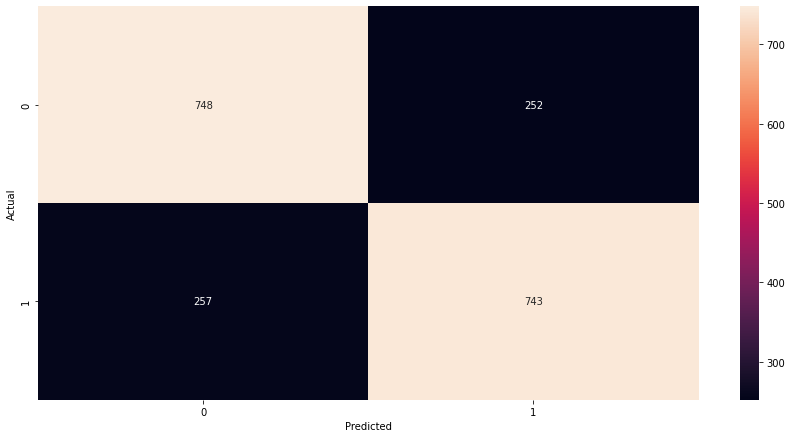

In [ ]:
#confusiin matrix
figure = plt.figure(figsize=(12, 6))
sns.heatmap(resnet_mat_df1, annot=True,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('ROC_resnet_biased_conf_matrix',dpi=300)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fprU, tprU, threshU = roc_curve(test_data.labels, y_pred, pos_label=1)

In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_scoreU = roc_auc_score(test_data.labels, y_pred)

In [ ]:
#auc score
print(auc_scoreU)


0.7454999999999999


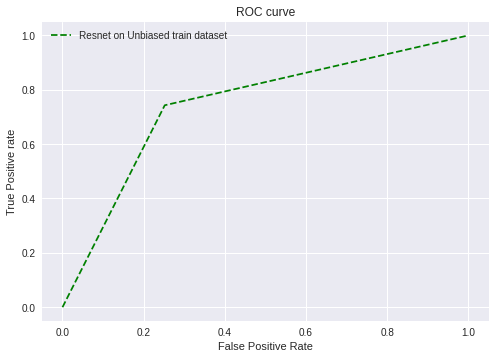

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fprU, tprU, linestyle='--',color='green', label='Resnet on Unbiased train dataset')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
#plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ResNet',dpi=300)
plt.show();

# ResNet On unbalanced Test Data

In [ ]:
resnmodel.load_weights("/content/drive/MyDrive/univ.ai2_project/resnmodel3.h5")

In [ ]:
y_pred = resnmodel.predict(test_data)


In [ ]:
y_pred= np.where(y_pred > 0.5,1,0)

In [ ]:
# resnet on unbalanced data
print(classification_report(test_data.labels,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75      1000
           1       0.75      0.74      0.74      1000

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fprU, tprU, threshU = roc_curve(test_data.labels, y_pred, pos_label=1)

In [ ]:
con_mat_df1 = pd.DataFrame(confusion_matrix(test_data.labels,y_pred))

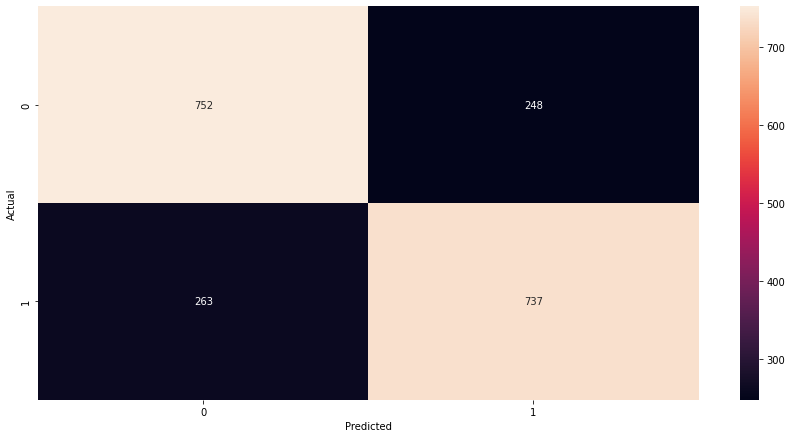

In [ ]:
#confusion matrix of unbalenced test set
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df1, annot=True,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('ROC_resnet_biased_conf_matrix',dpi=300)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fprU, tprU, threshU = roc_curve(test_data.labels, y_pred, pos_label=1)

In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_scoreU = roc_auc_score(test_data.labels, y_pred)

In [ ]:
print(auc_scoreU)

0.7445


In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fprU, tprU, threshU = roc_curve(test_data.labels, y_pred, pos_label=1)

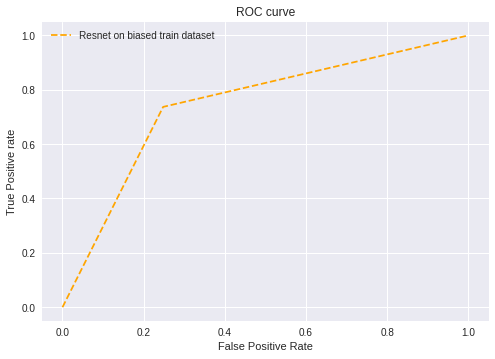

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fprU, tprU, linestyle='--',color='orange', label='Resnet on biased train dataset')
#plt.plot(fpr2, tpr2, linestyle='--',color='green', label='KNN')
#plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC_alex_net_biased',dpi=300)
plt.show();

In [6]:
from prettytable import PrettyTable

table=PrettyTable(["model", "Train_accuracy","validation_accuracy", "Test_accuracy","Test_accuracy_unbalanced_data" ])
table.add_row(["Custom model with 1 skip connection","0.72 ",'0.76','0.75','0.74'])
print(table)

+-------------------------------------+----------------+---------------------+---------------+-------------------------------+
|                model                | Train_accuracy | validation_accuracy | Test_accuracy | Test_accuracy_unbalanced_data |
+-------------------------------------+----------------+---------------------+---------------+-------------------------------+
| Custom model with 1 skip connection |     0.72       |         0.76        |      0.75     |              0.74             |
+-------------------------------------+----------------+---------------------+---------------+-------------------------------+
